In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import napari
from scipy.sparse import issparse
from tqdm import tqdm

In [2]:
def hex2rgb(hexstr):
    return tuple(int(hexstr[i:i+2], 16) for i in (0, 2, 4))

In [16]:
file_path = r'/media/brandon/Data2/Brandon/fly_immune/Flysta3d/L3_b_count_normal_stereoseq.h5ad'
f = h5py.File(file_path, 'r')


In [4]:
f.keys()

<KeysViewHDF5 ['X', 'layers', 'obs', 'obsm', 'uns', 'var']>

## Overview of anndata file structure

'X' is the cellxgene matrix---I'm not sure how it's normalized

In [167]:
print(f['X'][0])
f['X']

[0.        1.0553346 0.877426  ... 0.        0.        0.       ]


<HDF5 dataset "X": shape (43310, 16326), type "<f4">

'layers' only has one layer---the raw rna read counts

In [168]:
print(f['layers'].keys())
f['layers'].get('raw_counts')

<KeysViewHDF5 ['raw_counts']>


<HDF5 dataset "raw_counts": shape (43310, 16326), type "<f4">

'obs' has a few things. 

'_index' is a unique identifier for each cell. 

new_x, new_y, new+z are the spatial coordinates of each cell.

raw_x, raw_y, slice_ID are raw spatial coordinates of each cell

In [169]:
f['obs'].keys()

<KeysViewHDF5 ['__categories', '_index', 'annotation', 'new_x', 'new_y', 'new_z', 'raw_x', 'raw_y', 'slice_ID']>

of note, annotations contain the cell-type annotation numbers. 
I couldn't find these documented anywhere, but by comparing 3d renderings
I deduced that the **fat body is annotation == 4**.

In [170]:
f['obs'].get('annotation')

<HDF5 dataset "annotation": shape (43310,), type "|i1">

obsm = observation matrices. this contains a UMAP of the data, 
as well as 'spatial', which is an array of the 3d coordinates
of each cell, taken from new_x, new_y, new_z.

In [171]:
f['obsm'].keys()

<KeysViewHDF5 ['X_umap', 'spatial']>

uns has a list of colors for each cell type. the color is in 
byte-string form.

In [172]:
print(f['uns'].get('annotation_colors')[0])
f['uns'].keys()

b'#1f77b4'


<KeysViewHDF5 ['annotation_colors']>

to convert to RGB, decode the byte-string, remove the '#', and 
use the hex2rgb function above

In [173]:
hex2rgb(f['uns'].get('annotation_colors')[0].decode().lstrip('#'))

(31, 119, 180)

var has just geneID, which is the name of each gene

In [174]:
f['var'].keys()

<KeysViewHDF5 ['geneID']>

## UMAP
for fun, plot the umap

In [175]:
umap = np.array(f['obsm'].get('X_umap'))

In [4]:
a = np.array(f['obs'].get('annotation'))

In [177]:
np.unique(a)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int8)

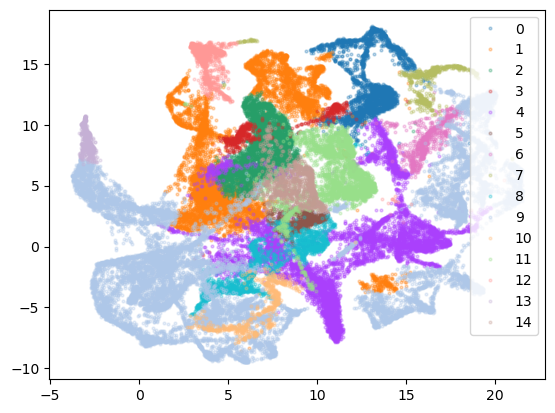

In [178]:
plt.figure()
for i in range(len(np.unique(a))):
    sel = (a == np.unique(a)[i])
    color = np.array(hex2rgb(f['uns'].get('annotation_colors')[i].decode().lstrip('#'))) / 255
    plt.plot(umap[sel,0], umap[sel,1], 'o', markersize=2, alpha=0.3, label=str(i), color=color)

plt.legend()

## View a 3D rendering of all the cells

In [100]:
viewer = napari.Viewer()

In [144]:
for i in range(len(np.unique(a))):
    sel = (a == np.unique(a)[i])
    color = np.array(hex2rgb(f['uns'].get('annotation_colors')[i].decode().lstrip('#'))) / 255
    viewer.add_points(points[sel], size=2, face_color=color)

# i think this is the correct zyx scaling
for layer in viewer.layers:
    layer.scale = (2.5, 1, 1)

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  r

## Look for genes that are expressed high in the anterior fat body and low in the posterior fat body

First, get the y coordinates of all the fat body cells and define the AP bins

In [5]:
# get selection of just fat body cells
a = np.array(f['obs'].get('annotation'))
sel = (a == 4)

In [6]:
# filter the data matrix
X = np.array(f.get('X'))
#X = X[sel, :]
X.shape

(43310, 16326)

In [7]:
# filter the spatial coordinate matrix
spatial = np.array(f['obsm'].get('spatial'))
spatial = spatial[sel, :]
spatial.shape

(6628, 3)

In [80]:
# get the y coordinates of fat body cells
ys = spatial[:, 1]
print(f'fat body cells range from y={np.min(ys)} to y={np.max(ys)}')

fat body cells range from y=-178.21475 to y=184.0076


In [81]:
# divide the fat body into thirds
y_bin_edges = np.linspace(np.min(ys), np.max(ys), 4)
print(y_bin_edges)

[-178.21475     -57.47396667   63.26681667  184.0076    ]


In [82]:
# divide the fat body into thirds
y_bin_edges = np.linspace(np.min(ys), np.max(ys), 4)
print(y_bin_edges)

y1 = y_bin_edges[1]
y2 = y_bin_edges[2]

# y1 = -129
# y2 = 73

sel_anterior = ys < y1
sel_middle = np.array(ys >= y1) * np.array(ys < y2)
sel_posterior = ys >= y2

# # divide the cell x gene matrix into anterior, middle, and posterior components
# X_anterior = X[sel_anterior]
# X_middle = X[sel_middle]
# X_posterior = X[sel_posterior]

[-178.21475     -57.47396667   63.26681667  184.0076    ]


Text(0, 0.5, 'counts')

<Figure size 640x480 with 0 Axes>

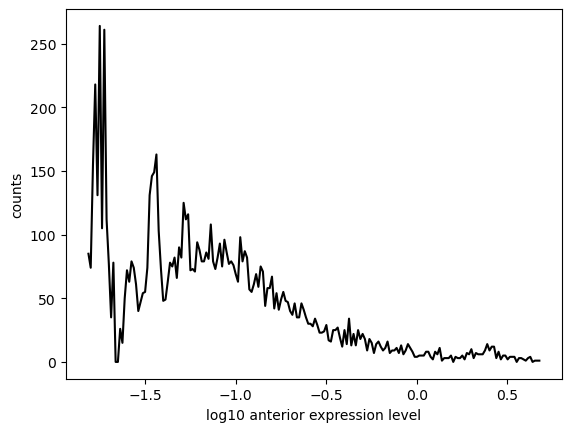

In [239]:
plt.figure()
m = np.nanmean(X_anterior, axis=0)
counts, bins = np.histogram(np.log10(m[m > 0]), bins=200)

plt.figure()
plt.plot(bins[:-1], counts, 'k-')
plt.xlabel('log10 anterior expression level')
plt.ylabel('counts')

/tmp/ipykernel_1796955/4148039227.py:1: RuntimeWarning: divide by zero encountered in true_divide
  anterior_middle_ratio = np.mean(X_anterior, axis=0) / np.mean(X_middle, axis=0)
/tmp/ipykernel_1796955/4148039227.py:1: RuntimeWarning: invalid value encountered in true_divide
  anterior_middle_ratio = np.mean(X_anterior, axis=0) / np.mean(X_middle, axis=0)


Text(0, 0.5, 'counts')

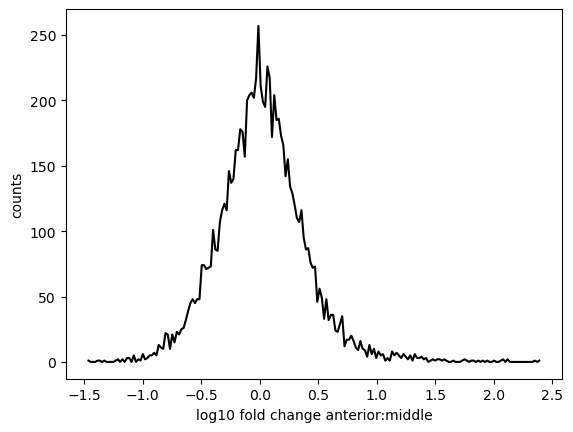

In [240]:
anterior_middle_ratio = np.mean(X_anterior, axis=0) / np.mean(X_middle, axis=0)

# remove genes with nan, inf, or 0 ratio from the histogram (but keep in the array)
good_genes = np.array(~np.isnan(anterior_middle_ratio)) * np.array(anterior_middle_ratio < np.inf) * np.array(anterior_middle_ratio > 0)

counts, bins = np.histogram(np.log10(anterior_middle_ratio[good_genes]), bins=200)
plt.figure()
plt.plot(bins[:-1], counts, 'k-')
plt.xlabel('log10 fold change anterior:middle')
plt.ylabel('counts')

/tmp/ipykernel_1796955/1154547808.py:1: RuntimeWarning: divide by zero encountered in true_divide
  posterior_middle_ratio = np.mean(X_posterior, axis=0) / np.mean(X_middle, axis=0)
/tmp/ipykernel_1796955/1154547808.py:1: RuntimeWarning: invalid value encountered in true_divide
  posterior_middle_ratio = np.mean(X_posterior, axis=0) / np.mean(X_middle, axis=0)


Text(0, 0.5, 'counts')

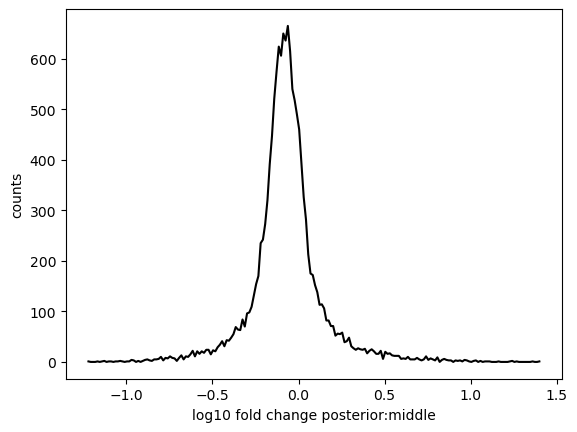

In [241]:
posterior_middle_ratio = np.mean(X_posterior, axis=0) / np.mean(X_middle, axis=0)

# remove genes with nan, inf, or 0 ratio from the histogram (but keep in the array)
good_genes = np.array(~np.isnan(posterior_middle_ratio)) * np.array(posterior_middle_ratio < np.inf) * np.array(posterior_middle_ratio > 0)

counts, bins = np.histogram(np.log10(posterior_middle_ratio[good_genes]), bins=200)
plt.figure()
plt.plot(bins[:-1], counts, 'k-')
plt.xlabel('log10 fold change posterior:middle')
plt.ylabel('counts')

In [22]:
gene_ids = f['var'].get('geneID')
gene_indices = np.arange(len(gene_ids))

In [242]:
low_genes = gene_indices[good_genes * np.array(anterior_middle_ratio < 0.5)]
len(low_genes)

6925

In [1]:
for i in range(len(low_genes)):
    print(gene_ids[low_genes[i]])

NameError: name 'low_genes' is not defined

/tmp/ipykernel_1796955/1547980394.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(np.nanstd(X_anterior, axis=0) / np.mean(X_anterior, axis=0))


(array([3357., 4646., 2018.,  967.,  630.,  583.,  180.,  482.,   33.,
         801.]),
 array([ 0.06208649,  2.9799757 ,  5.897865  ,  8.815754  , 11.733644  ,
        14.651532  , 17.569422  , 20.48731   , 23.4052    , 26.32309   ,
        29.240978  ], dtype=float32),
 <BarContainer object of 10 artists>)

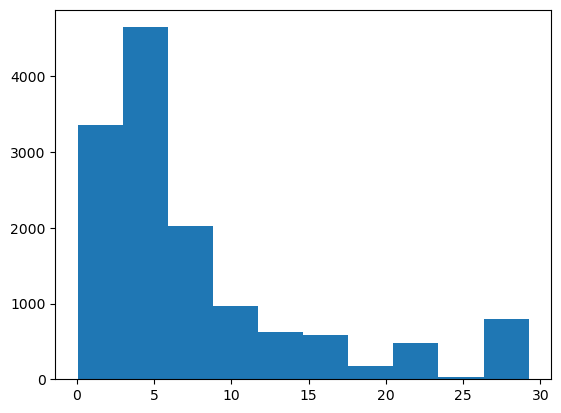

In [225]:
plt.hist(np.nanstd(X_anterior, axis=0) / np.mean(X_anterior, axis=0))

In [226]:
sm = np.nanstd(X_anterior, axis=0) / np.mean(X_anterior, axis=0)
np.sum(sm < 1)

/tmp/ipykernel_1796955/3643229204.py:1: RuntimeWarning: invalid value encountered in true_divide
  sm = np.nanstd(X_anterior, axis=0) / np.mean(X_anterior, axis=0)


466

## For fun, plot the distribution of rna counts of the whole transcriptome

In [245]:
all_reads = np.array(f['layers'].get('raw_counts')).flatten()


Text(0, 0.5, 'probability density')

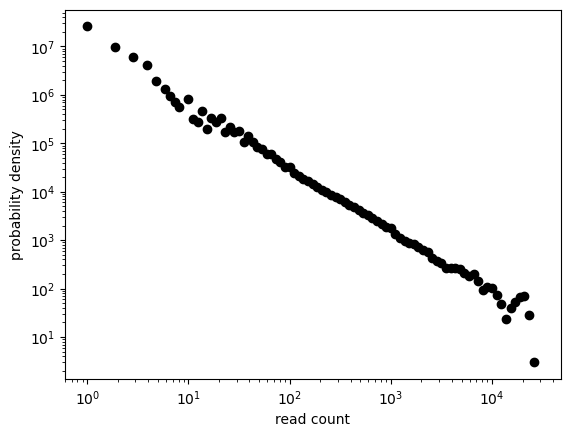

In [257]:
bins = np.logspace(0, 4.5, 100)
counts, bins = np.histogram(all_reads, bins=bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
plt.figure()
plt.plot(bins[:-1], counts, 'ko')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('read count')
plt.ylabel('probability density')


## Look at the dispersion of read counts

In [17]:
raw_reads =  np.array(f['layers'].get('raw_counts'))

In [259]:
fano = np.var(raw_reads, axis=0) / np.mean(raw_reads, axis=0)

Text(0, 0.5, 'counts')

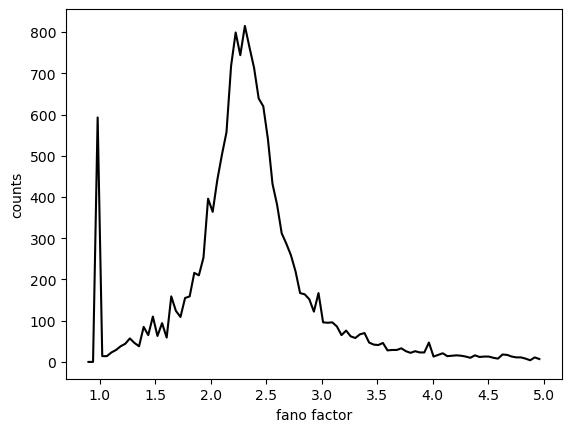

In [271]:
#bins = np.logspace(-0.01, 1, 100)
bins = np.linspace(0.9, 5, 100)
counts, bins = np.histogram(fano, bins=bins)
plt.plot(bins[:-1], counts, 'k-')
plt.xlabel('fano factor')
plt.ylabel('counts')

Text(0, 0.5, 'var count')

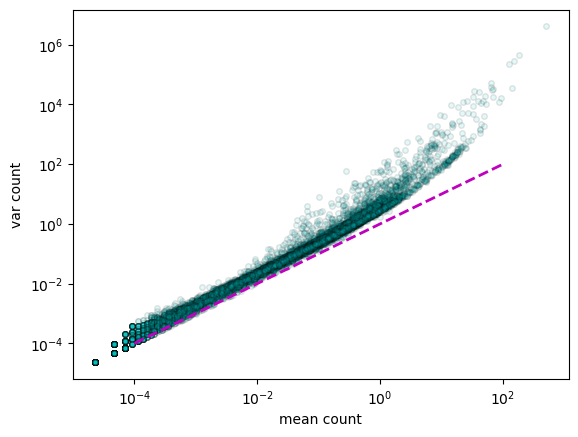

In [281]:
plt.figure()
plt.plot(np.mean(raw_reads, axis=0), np.var(raw_reads, axis=0), 'ko', markerfacecolor='c', markersize=4, alpha=0.1)
x = np.logspace(-4, 2)
plt.plot(x, x, 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean count')
plt.ylabel('var count')

## Compare to dispersion in their normalized data

In [68]:
X = np.array(f.get('X'))

Text(0, 0.5, 'var count')

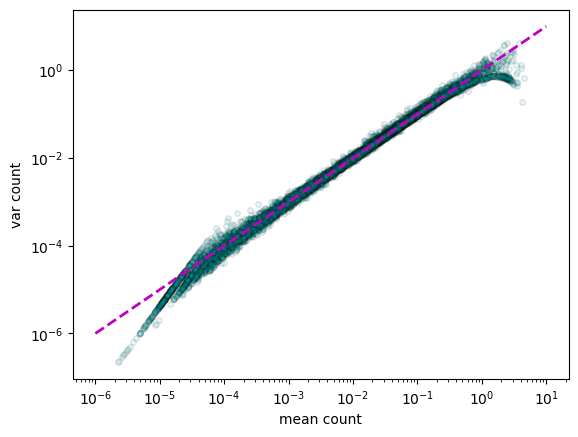

In [12]:
plt.figure()
plt.plot(np.mean(X, axis=0), np.var(X, axis=0), 'ko', markerfacecolor='c', markersize=4, alpha=0.1)
x = np.logspace(-6, 1)
plt.plot(x, x, 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean count')
plt.ylabel('var count')

In [8]:
"""from dynamo-release"""
def compute_pearson_residuals(X, theta=100.0, clip=None, 
                              copy=False, return_params=False):
    """Compute Pearson residuals from count data.

    Pearson residuals are a measure of the deviation of observed counts from expected counts under a Poisson or negative
    binomial model.

    Args:
        X: array_like count matrix, shape (n_cells, n_genes).
        theta: the dispersion parameter for the negative binomial model. Must be positive.
        clip: The maximum absolute value of the residuals. Residuals with absolute value larger than `clip` are clipped
            to `clip`. If `None`,`clip` is set to the square root of the number of cells in `X`.
        check_values: whether to check if `X` contains non-negative integers. If `True` and non-integer values are
            found, a `UserWarning` is issued.
        copy: whether to make a copy of `X`.

    Returns:
        The Pearson residuals.
    """
    X = X.copy() if copy else X

    # check theta
    if theta <= 0:
        # TODO: would "underdispersion" with negative theta make sense?
        # then only theta=0 were undefined..
        raise ValueError("Pearson residuals require theta > 0")
    # prepare clipping
    if clip is None:
        n = X.shape[0]
        clip = np.sqrt(n)
    if clip < 0:
        raise ValueError("Pearson residuals require `clip>=0` or `clip=None`.")

    if issparse(X):
        sums_genes = np.sum(X, axis=0)
        sums_cells = np.sum(X, axis=1)
        sum_total = np.sum(sums_genes).squeeze()
    else:
        sums_genes = np.sum(X, axis=0, keepdims=True)
        sums_cells = np.sum(X, axis=1, keepdims=True)
        sum_total = np.sum(sums_genes)

    mu = np.array(sums_cells @ sums_genes / sum_total)
    diff = np.array(X - mu)
    residuals = diff / np.sqrt(mu + mu**2 / theta)

    # clip
    residuals = np.clip(residuals, a_min=-clip, a_max=clip)
    
    if return_params:
        sigma = np.sqrt(mu + mu**2 / theta)
        return residuals, mu, sigma
    else:
        return residuals

In [18]:
"""filter reads to 5% detection"""
detection_percent = np.sum(raw_reads > 0, axis=0) / len(raw_reads)
filter_sel = detection_percent > 0.05
filtered_reads = raw_reads[:, filter_sel]

In [19]:
filtered_gene_ids = np.arange(filtered_reads.shape[1])

In [1]:
for i in range(len(gene_indices)):
    if filter_sel[i]:
        print(f'{gene_indices[i]}, {gene_ids[i]}')

NameError: name 'gene_indices' is not defined

In [295]:
plt.figure()
plt.plot(np.mean(filtered_reads, axis=0), np.var(filtered_reads, axis=0), 'co', alpha=0.3)
x = np.logspace(-1, 3)
plt.plot(x, x, 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean count')
plt.ylabel('var count')

Text(0, 0.5, 'var count')

In [20]:
residuals = compute_pearson_residuals(filtered_reads, theta=10)

/tmp/ipykernel_2503730/3855511579.py:46: RuntimeWarning: invalid value encountered in true_divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


In [355]:
plt.figure()
plt.plot(np.mean(filtered_reads, axis=0), np.nanvar(residuals, axis=0), 'ko', markerfacecolor='c', markersize=4, alpha=0.1)
x = np.logspace(np.log10(0.05), 2)
plt.plot(x, np.ones_like(x), 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('mean count')
plt.ylabel('var normalized count')


Text(0, 0.5, 'var normalized count')

In [356]:
plt.yscale('log')
plt.ylim(9e-1, 1e2)

(0.9, 100.0)

In [363]:
0.18 * (np.max(ys) - np.min(ys))

65.200023

In [364]:
np.min(ys) + 65

-113.21475000000001

## look at variable genes in the fat body

In [ ]:
sel = (a == 4)

In [267]:
fb_res = residuals[sel]
fb_res.shape

(6628, 6505)

In [349]:
plt.figure()
plt.plot(np.mean(filtered_reads[sel], axis=0), np.var(fb_res, axis=0), 'ko', markerfacecolor='c', markersize=4, alpha=0.1)
x = np.logspace(np.log10(0.05), 3)
plt.plot(x, np.ones_like(x), 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('mean count')
plt.ylabel('var normalized count')


Text(0, 0.5, 'var normalized count')

In [2]:
thresh = 10
variable_genes = gene_indices[np.var(fb_res, axis=0) > thresh]
for i in range(len(variable_genes)):
    print(gene_ids[variable_genes[i]])

NameError: name 'gene_indices' is not defined

## Differential expression analysis

In [86]:
theta = 1
fb_reads = raw_reads[sel]
res_a = compute_pearson_residuals(fb_reads[sel_anterior], theta=theta)
res_m = compute_pearson_residuals(fb_reads[sel_middle], theta=theta)
res_p = compute_pearson_residuals(fb_reads[sel_posterior], theta=theta)

/tmp/ipykernel_2187636/2996898540.py:45: RuntimeWarning: invalid value encountered in true_divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


In [173]:
m_a = np.mean(res_a, axis=0)
m_m = np.mean(res_m, axis=0)
m_p = np.mean(res_p, axis=0)

s_a = np.std(res_a, axis=0) / np.sqrt(len(s_a))
s_m = np.std(res_m, axis=0) / np.sqrt(len(s_m))

r = m_a / m_m
s = np.abs(r) * np.sqrt((s_a / m_a) ** 2 + (s_m / m_m) ** 2)

In [148]:
%matplotlib qt

In [162]:
s_a = s_a[~np.isnan(s)]
s_m = s_m[~np.isnan(s)]
s_plot = s[~np.isnan(s)]
r_plot = r[~np.isnan(r)]

significance = np.abs(r_plot) - 1 * s_plot > 0
#s_plot = s_plot[significance]
#r_plot = r_plot[significance]
plt.figure()
ids = np.argsort(r)
plt.plot(ids, r[ids], 'ko')
#plt.errorbar(ids, r[ids], s[ids])
#plt.ylim([-1e6, 1e6])

In [154]:
plt.figure()
plt.plot(r_plot, s_plot, 'ko', alpha=0.1)
plt.ylim([0, 2])
plt.xlim([-10, 10])

(-10.0, 10.0)

In [181]:
bins = np.linspace(-10, 10, 200)
counts, bins = np.histogram(r_plot, bins=bins)
plt.figure()
plt.plot(bins[:-1], counts, 'k-')
line = np.linspace(0, 700, 5)
plt.plot(np.zeros_like(line), line, 'k--')
plt.xlabel('fold change anterior:middle')
plt.ylabel('counts')


Text(0, 0.5, 'counts')

In [179]:
r_pm = m_p / m_m
r_pm = r_pm[~np.isnan(r_pm)]
bins = np.linspace(-10, 10, 200)
counts, bins = np.histogram(r_pm, bins=bins)
plt.figure()
plt.plot(bins[:-1], counts, 'k-')
line = np.linspace(0, 700, 5)
plt.plot(np.zeros_like(line), line, 'k--')
plt.xlabel('fold change anterior:middle')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

In [177]:
np.mean(r_pm)

0.1406968

### Difference?

In [126]:
diff = m_a - m_m
sig_diff = np.sqrt(s_a ** 2 + s_m ** 2)
plt.figure()
plt.plot(diff, sig_diff, 'ko', alpha=0.1)

In [204]:
for i in range(len(gene_ids)):
    print(f'{gene_indices[i]}, {gene_ids[i]}')

0, b'128up'
1, b'14-3-3epsilon'
2, b'14-3-3zeta'
3, b'140up'
4, b'18SrRNA-Psi:CR41602'
5, b'18w'
6, b'26-29-p'
7, b'28SrRNA-Psi:CR40596'
8, b'28SrRNA-Psi:CR40741'
9, b'28SrRNA-Psi:CR41609'
10, b'28SrRNA-Psi:CR45848'
11, b'28SrRNA-Psi:CR45851'
12, b'28SrRNA-Psi:CR45853'
13, b'28SrRNA-Psi:CR45855'
14, b'28SrRNA-Psi:CR45859'
15, b'28SrRNA-Psi:CR45860'
16, b'28SrRNA-Psi:CR45862'
17, b'2mit'
18, b'312'
19, b'4E-T'
20, b'5-HT1A'
21, b'5-HT1B'
22, b'5-HT2A'
23, b'5-HT2B'
24, b'5-HT7'
25, b'5.8SrRNA-Psi:CR45849'
26, b'5.8SrRNA-Psi:CR45854'
27, b'5.8SrRNA-Psi:CR45863'
28, b'5PtaseI'
29, b'5SrRNA-Psi:CR33356'
30, b'5SrRNA-Psi:CR33363'
31, b'5SrRNA-Psi:CR33416'
32, b'5SrRNA:CR33353'
33, b'5SrRNA:CR33362'
34, b'5SrRNA:CR33366'
35, b'5SrRNA:CR33367'
36, b'5SrRNA:CR33428'
37, b'5SrRNA:CR33441'
38, b'5SrRNA:CR33451'
39, b'5SrRNA:CR33452'
40, b'7B2'
41, b'7SLRNA:CR32864'
42, b'7SLRNA:CR42652'
43, b'825-Oak'
44, b'A16'
45, b'AANAT1'
46, b'AANATL2'
47, b'AANATL3'
48, b'AANATL4'
49, b'AANATL5'
50, b'AANA

2747, b'CG1750'
2748, b'CG17508'
2749, b'CG17514'
2750, b'CG17528'
2751, b'CG17544'
2752, b'CG17549'
2753, b'CG17556'
2754, b'CG17560'
2755, b'CG17562'
2756, b'CG17564'
2757, b'CG17565'
2758, b'CG17568'
2759, b'CG17570'
2760, b'CG17571'
2761, b'CG17572'
2762, b'CG17574'
2763, b'CG17575'
2764, b'CG17580'
2765, b'CG17593'
2766, b'CG17597'
2767, b'CG17598'
2768, b'CG17600'
2769, b'CG17601'
2770, b'CG17612'
2771, b'CG17625'
2772, b'CG17633'
2773, b'CG17636'
2774, b'CG17637'
2775, b'CG1764'
2776, b'CG17646'
2777, b'CG17648'
2778, b'CG17650'
2779, b'CG17652'
2780, b'CG17658'
2781, b'CG17660'
2782, b'CG17666'
2783, b'CG17669'
2784, b'CG17672'
2785, b'CG17681'
2786, b'CG17683'
2787, b'CG17684'
2788, b'CG17687'
2789, b'CG17691'
2790, b'CG17698'
2791, b'CG17707'
2792, b'CG17712'
2793, b'CG17715'
2794, b'CG17716'
2795, b'CG17717'
2796, b'CG17721'
2797, b'CG17724'
2798, b'CG17726'
2799, b'CG1773'
2800, b'CG17732'
2801, b'CG17734'
2802, b'CG17738'
2803, b'CG17739'
2804, b'CG1774'
2805, b'CG17744'
2

5407, b'CG4679'
5408, b'CG4681'
5409, b'CG4686'
5410, b'CG4691'
5411, b'CG4701'
5412, b'CG4702'
5413, b'CG4704'
5414, b'CG4707'
5415, b'CG4709'
5416, b'CG4712'
5417, b'CG4714'
5418, b'CG4716'
5419, b'CG4730'
5420, b'CG4733'
5421, b'CG4734'
5422, b'CG4741'
5423, b'CG4743'
5424, b'CG4744'
5425, b'CG4751'
5426, b'CG4752'
5427, b'CG4757'
5428, b'CG4763'
5429, b'CG4766'
5430, b'CG4768'
5431, b'CG4770'
5432, b'CG4781'
5433, b'CG4783'
5434, b'CG4788'
5435, b'CG4789'
5436, b'CG4793'
5437, b'CG4797'
5438, b'CG4806'
5439, b'CG4813'
5440, b'CG4815'
5441, b'CG4820'
5442, b'CG4822'
5443, b'CG4825'
5444, b'CG4829'
5445, b'CG4830'
5446, b'CG4835'
5447, b'CG4836'
5448, b'CG4839'
5449, b'CG4842'
5450, b'CG4847'
5451, b'CG4849'
5452, b'CG4853'
5453, b'CG4854'
5454, b'CG4858'
5455, b'CG4860'
5456, b'CG4866'
5457, b'CG4872'
5458, b'CG4880'
5459, b'CG4882'
5460, b'CG4884'
5461, b'CG4887'
5462, b'CG4891'
5463, b'CG4892'
5464, b'CG4896'
5465, b'CG4901'
5466, b'CG4907'
5467, b'CG4908'
5468, b'CG4911'
5469, b'

8021, b'Gp210'
8022, b'Gp93'
8023, b'Gpa2'
8024, b'Gpat4'
8025, b'Gpb5'
8026, b'Gpdh1'
8027, b'Gpdh2'
8028, b'Gpdh3'
8029, b'Gpo1'
8030, b'Gpo2'
8031, b'Gpo3'
8032, b'Gprk1'
8033, b'Gprk2'
8034, b'Gr10a'
8035, b'Gr22a'
8036, b'Gr22b'
8037, b'Gr22c'
8038, b'Gr22d'
8039, b'Gr22e'
8040, b'Gr22f'
8041, b'Gr23a'
8042, b'Gr28a'
8043, b'Gr28b'
8044, b'Gr2a'
8045, b'Gr32a'
8046, b'Gr33a'
8047, b'Gr36a'
8048, b'Gr36c'
8049, b'Gr39a'
8050, b'Gr39b'
8051, b'Gr43a'
8052, b'Gr47a'
8053, b'Gr47b'
8054, b'Gr58a'
8055, b'Gr58b'
8056, b'Gr58c'
8057, b'Gr59a'
8058, b'Gr59b'
8059, b'Gr59c'
8060, b'Gr59d'
8061, b'Gr59e'
8062, b'Gr59f'
8063, b'Gr5a'
8064, b'Gr61a'
8065, b'Gr63a'
8066, b'Gr64a'
8067, b'Gr64c'
8068, b'Gr64d'
8069, b'Gr64f'
8070, b'Gr66a'
8071, b'Gr68a'
8072, b'Gr77a'
8073, b'Gr85a'
8074, b'Gr89a'
8075, b'Gr8a'
8076, b'Gr92a'
8077, b'Gr93c'
8078, b'Gr93d'
8079, b'Gr94a'
8080, b'Gr97a'
8081, b'Gr98a'
8082, b'Gr98b'
8083, b'Gr98c'
8084, b'Gr98d'
8085, b'Gr9a'
8086, b'Graf'
8087, b'GramD1B'
8088

10720, b'TbCMF46'
10721, b'Tbc1d15-17'
10722, b'Tbce'
10723, b'Tbh'
10724, b'Tbp'
10725, b'Tcs3'
10726, b'Tctp'
10727, b'Tdc1'
10728, b'Tdc2'
10729, b'Tdrd3'
10730, b'Teh1'
10731, b'Teh2'
10732, b'Teh3'
10733, b'Teh4'
10734, b'Tehao'
10735, b'Tektin-A'
10736, b'Tektin-C'
10737, b'Ten-a'
10738, b'Ten-m'
10739, b'Tengl1'
10740, b'Tengl2'
10741, b'Tengl3'
10742, b'Tengl4'
10743, b'Tep1'
10744, b'Tep2'
10745, b'Tep3'
10746, b'Tep4'
10747, b'Tep5Psi'
10748, b'Tes'
10749, b'Tet'
10750, b'TfAP-2'
10751, b'TfIIA-L'
10752, b'TfIIA-S'
10753, b'TfIIA-S-2'
10754, b'TfIIB'
10755, b'TfIIEalpha'
10756, b'TfIIEbeta'
10757, b'TfIIFalpha'
10758, b'TfIIFbeta'
10759, b'TfIIS'
10760, b'Tfb1'
10761, b'Tfb4'
10762, b'Tfb5'
10763, b'Tg'
10764, b'Tgi'
10765, b'Tgs1'
10766, b'Tgt'
10767, b'Thd1'
10768, b'Thor'
10769, b'ThrRS'
10770, b'Tie'
10771, b'Tif-IA'
10772, b'Tig'
10773, b'Tim10'
10774, b'Tim13'
10775, b'Tim17a1'
10776, b'Tim17a2'
10777, b'Tim17b'
10778, b'Tim17b1'
10779, b'Tim17b2'
10780, b'Tim23'
10781,

13380, b'lncRNA:CR44523'
13381, b'lncRNA:CR44524'
13382, b'lncRNA:CR44526'
13383, b'lncRNA:CR44527'
13384, b'lncRNA:CR44528'
13385, b'lncRNA:CR44529'
13386, b'lncRNA:CR44530'
13387, b'lncRNA:CR44531'
13388, b'lncRNA:CR44534'
13389, b'lncRNA:CR44535'
13390, b'lncRNA:CR44536'
13391, b'lncRNA:CR44537'
13392, b'lncRNA:CR44538'
13393, b'lncRNA:CR44539'
13394, b'lncRNA:CR44540'
13395, b'lncRNA:CR44542'
13396, b'lncRNA:CR44543'
13397, b'lncRNA:CR44544'
13398, b'lncRNA:CR44545'
13399, b'lncRNA:CR44547'
13400, b'lncRNA:CR44548'
13401, b'lncRNA:CR44549'
13402, b'lncRNA:CR44551'
13403, b'lncRNA:CR44552'
13404, b'lncRNA:CR44553'
13405, b'lncRNA:CR44554'
13406, b'lncRNA:CR44558'
13407, b'lncRNA:CR44559'
13408, b'lncRNA:CR44560'
13409, b'lncRNA:CR44561'
13410, b'lncRNA:CR44562'
13411, b'lncRNA:CR44563'
13412, b'lncRNA:CR44564'
13413, b'lncRNA:CR44565'
13414, b'lncRNA:CR44566'
13415, b'lncRNA:CR44567'
13416, b'lncRNA:CR44568'
13417, b'lncRNA:CR44570'
13418, b'lncRNA:CR44571'
13419, b'lncRNA:CR44572'


16017, b'tRNA:Thr-TGT-2-1'
16018, b'tRNA:Thr-TGT-2-2'
16019, b'tRNA:Thr-TGT-2-3'
16020, b'tRNA:Thr-TGT-2-4'
16021, b'tRNA:Trp-CCA-2-2'
16022, b'tRNA:Trp-CCA-2-5'
16023, b'tRNA:Trp-CCA-2-6'
16024, b'tRNA:Tyr-GTA-1-4'
16025, b'tRNA:Tyr-GTA-1-5'
16026, b'tRNA:Tyr-GTA-1-6'
16027, b'tRNA:Tyr-GTA-1-7'
16028, b'tRNA:Tyr-GTA-1-8'
16029, b'tRNA:Tyr-GTA-1-9'
16030, b'tRNA:Val-AAC-1-1'
16031, b'tRNA:Val-AAC-2-1'
16032, b'tRNA:Val-AAC-2-3'
16033, b'tRNA:Val-AAC-2-4'
16034, b'tRNA:Val-CAC-1-1'
16035, b'tRNA:Val-CAC-2-1'
16036, b'tRNA:Val-CAC-2-3'
16037, b'tRNA:Val-CAC-2-6'
16038, b'tRNA:Val-TAC-1-1'
16039, b'tRNA:Val-TAC-1-2'
16040, b'tRNA:iMet-CAT-1-1'
16041, b'tRNA:iMet-CAT-1-2'
16042, b'tRNA:iMet-CAT-1-3'
16043, b'tRNA:iMet-CAT-1-4'
16044, b'tRNA:iMet-CAT-1-5'
16045, b'tRNA:iMet-CAT-2-1'
16046, b'tacc'
16047, b'tadr'
16048, b'tai'
16049, b'tal-2A'
16050, b'tam'
16051, b'tamo'
16052, b'tank'
16053, b'tant'
16054, b'tap'
16055, b'tapas'
16056, b'tara'
16057, b'tau'
16058, b'tay'
16059, b'tbrd-1'
1

# Plot AP dists of individual genes

In [231]:
# bin ys
n_y_bins = 30
y_bins = np.linspace(np.min(ys), np.max(ys), n_y_bins)
binned_ys = bin_aps(ys, y_bins)



In [224]:
binned_ys

array([3., 3., 3., ..., 4., 4., 5.])

In [9]:
def bin_aps(aps, bins):
    _counts, bins = np.histogram(aps, bins)
    bins = bins[1:]
    binned_aps = np.zeros_like(aps)
    for i in range(len(binned_aps)):
        binned_aps[i] = get_ap_bin(aps[i], bins)
    
    return binned_aps
    

def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin


def bin_exp(exp, binned_ys, y_bins, n_bootstraps=300):
    binned_exp = np.zeros_like(y_bins)
    std_exp = np.zeros_like(y_bins)
    for i in range(len(y_bins)):
        these_expression_levels = exp[y_bins[binned_ys.astype('int')] == y_bins[i]]
        binned_exp[i] = np.nanmean(these_expression_levels)
        bootstrapped_means = np.zeros(n_bootstraps)
        for n in range(n_bootstraps):
            these_expression_levels = np.random.choice(these_expression_levels, len(these_expression_levels))
            bootstrapped_means[n] = np.mean(these_expression_levels)
        std_exp[i] = np.nanstd(bootstrapped_means)
    return binned_exp, std_exp


def get_filtered_index(index, gene_list, filtered_gene_list):
    this_gene = gene_list[index]
    filtered_index = np.where(np.array([g == this_gene for g in filtered_gene_list]))[0][0]
    
    return filtered_index
    
    
def get_binned_line_dist(index, residuals, binned_ys, y_bins, gene_list, filtered_gene_list):
    filtered_index = get_filtered_index(index, gene_list, filtered_gene_list)
    expression = residuals[:, filtered_index]
    binned_expression, _ = bin_exp(expression, binned_ys, y_bins)
    
    return binned_expression
    

def get_line_dist_uncertainty(index, residuals, binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100):
    line_dist_arr = np.zeros((n_bootstraps, len(y_bins)))
    for i in range(n_bootstraps):
        scrambled_ys = np.random.choice(binned_ys, len(binned_ys))
        line_dist_arr[i] = get_binned_line_dist(index, residuals, scrambled_ys, y_bins, gene_list, filtered_gene_list)

    return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)

# Individual gene AP dists

In [23]:
"""convert gene_ids to more convenient lists"""
gene_list = [gene.decode() for gene in gene_ids]
filtered_gene_list = [gene.decode() for gene in filtered_gene_ids]

AttributeError: 'numpy.int64' object has no attribute 'decode'

## DptA

In [189]:
dptA_id = 7604

In [324]:
residuals.shape

(43310, 6505)

In [442]:
dptA_exp = corrected_counts[:, get_filtered_index(dptA_id, gene_list, filtered_gene_list)]
dptA_exp = dptA_exp[sel]

In [323]:
dptA_exp

array([-0.29109192, -0.18444227, -0.18306085, ..., -0.21708131,
       -0.23118807, -0.20594232], dtype=float32)

In [198]:
spatial = np.array(f['obsm'].get('spatial'))
spatial = spatial[sel]

In [325]:
plt.figure()
plt.plot(ys, dptA_exp, 'ko', alpha=0.5)

In [443]:
binned_dptA, std_dptA = bin_exp(dptA_exp, binned_ys, y_bins)
mean_scramble, std_scramble = get_line_dist_uncertainty(dptA_id, corrected_counts[sel], binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100)
m = mean_scramble
s = std_scramble
l = m - s
u = m + s
plt.figure()

plt.fill_between(y_bins, l, u, color='k', alpha=0.3)
plt.errorbar(y_bins, binned_dptA, std_dptA, color='g', linewidth=4)
#plt.errorbar(y_bins, binned_dptA, bootstrapped_uncertainty)

plt.xlabel('ap')
plt.ylabel('dptA')
#plt.xlim([-113, np.max(ys)])

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


Text(0, 0.5, 'dptA')

In [235]:
# His2B: note, not in filtered genes
his2b_id = 8236
h2b_exp = residuals[sel, his2b_id]
plt.figure()
plt.plot(ys, h2b_exp, 'ko', alpha=0.5)

In [238]:
binned_h2b = bin_exp(h2b_exp, binned_ys, y_bins)
plt.figure()
plt.plot(y_bins, binned_h2b)
plt.xlabel('ap')
plt.ylabel('h2b')

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'h2b')

In [388]:
for gene in filtered_gene_list:
    print(gene)

128up
14-3-3epsilon
14-3-3zeta
18SrRNA-Psi:CR41602
26-29-p
28SrRNA-Psi:CR40596
28SrRNA-Psi:CR40741
28SrRNA-Psi:CR41609
28SrRNA-Psi:CR45851
28SrRNA-Psi:CR45855
28SrRNA-Psi:CR45859
28SrRNA-Psi:CR45860
28SrRNA-Psi:CR45862
312
4E-T
7B2
7SLRNA:CR32864
7SLRNA:CR42652
A16
AANAT1
AANATL2
ABCB7
ABCD
ACC
ACXC
ADD1
AGBE
AGO1
AGO2
AGO3
AIF
AIMP1
AIMP2
AIMP3
ALiX
AMPKalpha
AMPdeam
AOX1
AOX3
AP-1-2beta
AP-1gamma
AP-1mu
AP-1sigma
AP-2alpha
AP-2mu
AP-2sigma
APP-BP1
ASPP
ATP6AP2
ATP7
ATP8A
ATPCL
ATPsynB
ATPsynC
ATPsynCF6
ATPsynCF6L
ATPsynD
ATPsynE
ATPsynF
ATPsynG
ATPsynGL
ATPsynO
ATPsynbeta
ATPsyndelta
ATPsynepsilonL
ATPsyngamma
Abi
Abl
Abp1
AcCoAS
Acam
Acbp1
Acbp2
Acbp3
Acbp4
Acbp5
Acbp6
Ace
Acer
Ack
Acn
Acph-1
Acsl
Act42A
Act57B
Act5C
Act87E
Actn
Acyp
Acyp2
AdSL
AdSS
Ada2a
Adat1
AdenoK
Adf1
Adgf-A2
Adgf-D
Adgf-E
Adh
Adi1
AdipoR
Adk1
Adk2
Adk3
Ag5r
Ag5r2
Agpat2
Agpat3
Agpat4
Ahcy
AhcyL1
AhcyL2
Akap200
Akh
AkhR
Akt1
AlaRS
Aladin
Alas
Ald1
Ald2
Aldh
Aldh-III
Aldh7A1
Alg-2
Alg1
Alg10
Alg11
Alg2
Alg3
Alh


In [386]:
binned_h2b, std_h2b = bin_exp(h2b_exp, binned_ys, y_bins)
plt.figure()
mean_scramble, std_scramble = get_line_dist_uncertainty(his2b_id, residuals[sel], binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100)
m = mean_scramble
s = std_scramble
l = m - s
u = m + s
plt.fill_between(y_bins, l, u, color='k', alpha=0.3)
plt.errorbar(y_bins, binned_h2b, std_h2b, linewidth=4, color='m')
#plt.errorbar(y_bins, binned_dptA, bootstrapped_uncertainty)

plt.xlabel('ap')
plt.ylabel('h2b')
#plt.xlim([-113, np.max(ys)])

/tmp/ipykernel_2187636/2722339132.py:21: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(exp[y_bins[binned_ys.astype('int')] == y_bins[i]])
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


IndexError: index 0 is out of bounds for axis 0 with size 0

In [243]:
# plot dptA and H2b on the same graph
fig = plt.figure()
plt.plot(y_bins, binned_dptA, color='g', label='dptA')
plt.plot(y_bins, binned_h2b, color='m', label='h2b')

plt.xlabel('ap')
plt.ylabel('norm. expression level')
plt.legend()

In [242]:
# plot dptA and H2b on the same graph
fig, ax1 = plt.subplots()
ax1.plot(y_bins, binned_dptA, color='g', label='dptA')
ax1.set_ylabel('dptA', color='g')
ax2 = ax1.twinx()
ax2.plot(y_bins, binned_h2b, color='m', label='h2b')
ax2.set_ylabel('h2b', color='m')

plt.xlabel('ap')
#plt.ylabel('norm. expression level')
#plt.legend()

Text(0.5, 0, 'ap')

In [211]:
np.min(dptA_exp)

-0.5980585

In [246]:
# Ecr:
ecr_id = 7689
ecr_exp = residuals[sel, ecr_id]
plt.figure()
plt.plot(ys, ecr_exp, 'ko', alpha=0.5)

In [245]:
binned_ecr = bin_exp(ecr_exp, binned_ys, y_bins)
plt.figure()
plt.plot(y_bins, binned_ecr)
plt.xlabel('ap')
plt.ylabel('ecr')

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'ecr')

In [403]:
binned_ecr, std_ecr = bin_exp(ecr_exp, binned_ys, y_bins)
mean_scramble, std_scramble = get_line_dist_uncertainty(ecr_id, residuals[sel], binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100)
m = mean_scramble
s = std_scramble
l = m - s
u = m + s

plt.figure()
plt.fill_between(y_bins, l, u, color='k', alpha=0.3)
plt.errorbar(y_bins, binned_ecr, std_ecr, linewidth=4, color='c')
#plt.errorbar(y_bins, binned_dptA, bootstrapped_uncertainty)

plt.xlabel('ap')
plt.ylabel('ecr')
#plt.xlim([-113, np.max(ys)])

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

Text(0, 0.5, 'ecr')

In [393]:
# pgrp-lc
pgrp_lc_id = 9418
pgrp_lc = residuals[sel, get_filtered_index(pgrp_lc_id, gene_list, filtered_gene_list)]
plt.figure()
plt.plot(ys, pgrp_lc, 'ko', alpha=0.5)

In [404]:
binned_pgrp, std_pgrp = bin_exp(pgrp_lc, binned_ys, y_bins)
mean_scramble, std_scramble = get_line_dist_uncertainty(pgrp_lc_id, residuals[sel], binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100)
m = mean_scramble
s = std_scramble
l = m - s
u = m + s

plt.figure()
plt.fill_between(y_bins, l, u, color='k', alpha=0.3)
plt.errorbar(y_bins, binned_pgrp, std_pgrp, linewidth=4, color='c')
#plt.errorbar(y_bins, binned_dptA, bootstrapped_uncertainty)

plt.xlabel('ap')
plt.ylabel('pgrplc')
#plt.xlim([-113, np.max(ys)])
plt.ylim([-1.0, 2.5])

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._m

/tmp/ipykernel_2187636/798156677.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/798156677.py:54: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom

(-1.0, 2.5)

# Devise a test for anterior-biased expression

In [10]:
def compute_anterior_middle_ratio(gene_id, residuals, 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=300, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50):
    
    exp = residuals[:, get_filtered_index(gene_id, gene_list, 
                                          filtered_gene_list)]
    binned_exp, std_exp = bin_exp(exp, binned_ys, y_bins, 
                                  n_bootstraps=n_bootstraps)
    mean_scramble, std_scramble = get_line_dist_uncertainty(
                gene_id, residuals, binned_ys, y_bins, gene_list, 
                filtered_gene_list, n_bootstraps=n_bootstraps)
    
    anterior_ids = (y_bins >= a_start) & (y_bins < a_end)
    middle_ids = (y_bins >= m_start) & (y_bins < m_end)

    anterior_signal = np.mean(binned_exp[anterior_ids])
    middle_signal = np.mean(binned_exp[middle_ids])
    
    ratio = anterior_signal / middle_signal
    sigma_anterior = np.sqrt(np.mean(std_exp[anterior_ids] ** 2) / np.sum(anterior_ids))
    sigma_middle = np.sqrt(np.mean(std_exp[middle_ids] ** 2) / np.sum(middle_ids))
    sigma_ratio = np.sqrt(ratio ** 2 * (sigma_anterior ** 2 / anterior_signal ** 2
                                       + sigma_middle **2 / middle_signal ** 2))
    

    anterior_scramble = np.mean(mean_scramble[anterior_ids])
    middle_scramble = np.mean(mean_scramble[middle_ids])
    
    scramble_ratio = anterior_scramble / middle_scramble
    sigma_scramble_anterior = np.sqrt(np.mean(std_scramble[anterior_ids] ** 2) / np.sum(anterior_ids))
    sigma_scramble_middle = np.sqrt(np.mean(std_scramble[middle_ids] ** 2) / np.sum(middle_ids))
    sigma_scramble_ratio = np.sqrt(scramble_ratio ** 2 * (sigma_scramble_anterior ** 2 / anterior_signal ** 2
                                       + sigma_scramble_middle **2 / middle_scramble ** 2))
    
    
    
    return ratio, sigma_ratio, scramble_ratio, sigma_scramble_ratio

        

def compute_anterior_middle_difference(gene_id, X, 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=300, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50):
    
    exp = X[:, get_filtered_index(gene_id, gene_list, 
                                          filtered_gene_list)]
    binned_exp, std_exp = bin_exp(exp, binned_ys, y_bins, 
                                  n_bootstraps=n_bootstraps)
    mean_scramble, std_scramble = get_line_dist_uncertainty(
                gene_id, X, binned_ys, y_bins, gene_list, 
                filtered_gene_list, n_bootstraps=n_bootstraps)
    
    anterior_ids = (y_bins >= a_start) & (y_bins < a_end)
    middle_ids = (y_bins >= m_start) & (y_bins < m_end)

    anterior_signal = np.mean(binned_exp[anterior_ids])
    middle_signal = np.mean(binned_exp[middle_ids])
    
    difference = anterior_signal - middle_signal
    sigma_anterior = np.sqrt(np.mean(std_exp[anterior_ids] ** 2) / np.sum(anterior_ids))
    sigma_middle = np.sqrt(np.mean(std_exp[middle_ids] ** 2))
    sigma_difference = np.sqrt((sigma_anterior ** 2 + sigma_middle **2) / np.sum(middle_ids))
    

    anterior_scramble = np.mean(mean_scramble[anterior_ids])
    middle_scramble = np.mean(mean_scramble[middle_ids])
    
    scramble_difference = anterior_scramble - middle_scramble
    sigma_scramble_anterior = np.sqrt(np.mean(std_scramble[anterior_ids] ** 2) / np.sum(anterior_ids))
    sigma_scramble_middle = np.sqrt(np.mean(std_scramble[middle_ids] ** 2) / np.sum(middle_ids))
    sigma_scramble_difference = np.sqrt((sigma_scramble_anterior ** 2 + sigma_scramble_middle **2))
    
    
    
    return difference, sigma_difference, scramble_difference, sigma_scramble_difference

        


In [405]:
a_start = -113
a_end = -113 + 50

m_start = 0
m_end = 50


In [459]:
X_filt = X[:, filter_sel]

In [463]:
corrected_counts_filt = corrected_counts[:, filter_sel]

In [476]:
ratio, sigma_ratio, scramble_ratio, sigma_scramble_ratio = compute_anterior_middle_ratio(dptA_id, residuals[sel], 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=300, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50)

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


In [477]:
plt.figure()
x = 0
plt.errorbar(x, ratio, sigma_ratio, marker='o')
x = 1
plt.errorbar(x, scramble_ratio, sigma_scramble_ratio, marker='o')
plt.xticks([0, 1], labels=['dptA', 'scramble'])
plt.xlim([-0.5, 1.5])
plt.ylabel('anterior:middle ratio')

Text(0, 0.5, 'anterior:middle ratio')

In [467]:
np.max(X)

8.72502

In [449]:
def correct_counts(X, theta=50):
    residuals, mu, sigma = compute_pearson_residuals(X, theta=theta, return_params=True)
    corrected_counts = np.floor(residuals * sigma + mu)
    corrected_counts[corrected_counts  < 0] = 0
    
    return corrected_counts

In [450]:
corrected_counts = correct_counts(raw_reads)

In [451]:
plt.figure()
plt.plot(np.mean(corrected_counts[:, filter_sel], axis=0), np.var(corrected_counts[:, filter_sel], axis=0), 'ko', markerfacecolor='c', markersize=4, alpha=0.1)
x = np.logspace(np.log10(0.05), 3)
plt.plot(x, x, 'm--', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean count')
plt.ylabel('var count')

Text(0, 0.5, 'var count')

In [504]:
difference, sigma_difference, scramble_difference, sigma_scramble_difference = compute_anterior_middle_difference(dptA_id, residuals[sel], 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=10, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50)

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


In [505]:
plt.figure()
x = 0
plt.errorbar(x, difference, sigma_difference, marker='o')
x = 1
plt.errorbar(x, scramble_difference, sigma_scramble_difference, marker='o')
plt.xticks([0, 1], labels=['dptA', 'scramble'])
plt.xlim([-0.5, 1.5])
plt.ylabel('anterior - middle residuals')

Text(0, 0.5, 'anterior - middle residuals')

In [494]:
len(filtered_gene_indices)

6505

In [512]:
all_differences = np.zeros(len(filtered_gene_list))
all_sigma_differences = np.zeros(len(filtered_gene_list))
all_scramble_differences = np.zeros(len(filtered_gene_list))
all_sigma_scramble_differences = np.zeros(len(filtered_gene_list))


for i in tqdm(range(len(filtered_gene_list))):
    this_id = np.where(np.array([g == filtered_gene_list[i] for g in gene_list]))[0][0]
    all_differences[i], all_sigma_differences[i], all_scramble_differences[i], all_sigma_scramble_differences[i] = compute_anterior_middle_difference(this_id, residuals[sel], 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=10, a_start=a_start, 
                                  a_end=a_end, m_start=m_start, m_end=m_end)

  0%|                                                                                                                                                                            | 0/6505 [00:00<?, ?it/s]/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6505/6505 [2:24:32<00:00,  1.33s/it]


In [11]:
import pickle

In [514]:
with open(r'/media/brandon/Data2/Brandon/fly_immune/Flysta3d/anterior-middle-differences.pkl', 'wb') as f:
    pickle.dump((all_differences, all_sigma_differences, all_scramble_differences, all_sigma_scramble_differences), f)

In [12]:
with open(r'/media/brandon/Data2/Brandon/fly_immune/Flysta3d/anterior-middle-differences.pkl', 'rb') as f:
    all_differences, all_sigma_differences, all_scramble_differences, all_sigma_scramble_differences  =  pickle.load(f)

In [13]:
# filter by error bars
high_expressing = all_differences - all_sigma_differences > (all_scramble_differences + all_sigma_scramble_differences)
low_expressing = all_differences + all_sigma_differences < (all_scramble_differences - all_sigma_scramble_differences)

# filter by effect size
difference_thresh = 2
high_expressing = high_expressing * (all_differences > difference_thresh)
low_expressing = low_expressing * (all_differences < -1 * difference_thresh)

In [516]:
np.sum(high_expressing)

1674

In [519]:
np.sum(low_expressing)

3525

In [546]:
high_expressing_genes = [filtered_gene_list[i] for i in range(len(filtered_gene_list)) if high_expressing[i]]
low_expressing_genes = [filtered_gene_list[i] for i in range(len(filtered_gene_list)) if low_expressing[i]]

In [547]:
for g in high_expressing_genes:
    this_id = np.where(np.array([gg == g for gg in gene_list]))[0][0]

    print(f'{gene_indices[this_id]}, {g}')

1902, CG14302
2329, CG15369
4737, CG42587
5979, CG6870
6276, CG7953
7808, Fbp1
8682, LysS
10822, TotA
12109, deltaTry
12787, lncRNA:CR33938
12797, lncRNA:CR34335
12802, lncRNA:CR40469
15171, regucalcin


In [548]:
for g in low_expressing_genes:
    this_id = np.where(np.array([gg == g for gg in gene_list]))[0][0]

    print(f'{gene_indices[this_id]}, {g}')

1104, CG12116
1211, CG12522
1254, CG12699
1628, CG13641
2548, CG16713
2603, CG16926
2729, CG17376
3296, CG30430
3409, CG31226
3440, CG31313
3648, CG31988
3672, CG32073
4216, CG34166
4218, CG34168
5341, CG46059
5418, CG4716
5700, CG5773
6918, CR43186
8671, Lsp1beta
8672, Lsp1gamma
8673, Lsp2
8896, Mst84Db
8898, Mst84Dd
8900, Mst87F
9229, ORY
10150, S-Lap1
10153, S-Lap4
11345, asRNA:CR11538
14921, ocn
15101, pre-rRNA:CR45856


In [502]:
gene_list[190]

'Adi1'

In [534]:
this_id = 4
difference, sigma_difference, scramble_difference, sigma_scramble_difference = compute_anterior_middle_difference(this_id, residuals[sel], 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=10, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50)

plt.figure()
x = 0
plt.errorbar(x, difference, sigma_difference, marker='o')
x = 1
plt.errorbar(x, scramble_difference, sigma_scramble_difference, marker='o')
plt.xticks([0, 1], labels=[f'{gene_list[this_id]}', 'scramble'])
plt.xlim([-0.5, 1.5])
plt.ylabel('anterior - middle residuals')

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


Text(0, 0.5, 'anterior - middle residuals')

In [535]:
sorted_ids = np.argsort(all_differences)

In [540]:
this_id = np.where(np.array([gg == filtered_gene_list[sorted_ids[-1]] for gg in gene_list]))[0][0]
difference, sigma_difference, scramble_difference, sigma_scramble_difference = compute_anterior_middle_difference(this_id, residuals[sel], 
                                  binned_ys, y_bins, 
                                  gene_list, filtered_gene_list, 
                                  n_bootstraps=10, a_start=-113.0, 
                                  a_end=-63, m_start=0, m_end=50)

plt.figure()
x = 0
plt.errorbar(x, difference, sigma_difference, marker='o')
x = 1
plt.errorbar(x, scramble_difference, sigma_scramble_difference, marker='o')
plt.xticks([0, 1], labels=[f'{gene_list[this_id]}', 'scramble'])
plt.xlim([-0.5, 1.5])
plt.ylabel('anterior - middle residuals')

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


Text(0, 0.5, 'anterior - middle residuals')

In [542]:
this_id

10822

In [551]:
#this_id = 10822    # totA
#this_id = 15171    # regulacin
this_id = 8673 
expression = residuals[sel, get_filtered_index(this_id, gene_list, filtered_gene_list)]
plt.figure()
plt.plot(ys, pgrp_lc, 'ko', alpha=0.5)

binned_exp, std_exp = bin_exp(expression, binned_ys, y_bins)
mean_scramble, std_scramble = get_line_dist_uncertainty(this_id, residuals[sel], binned_ys, y_bins, gene_list, filtered_gene_list, n_bootstraps=100)
m = mean_scramble
s = std_scramble
l = m - s
u = m + s

plt.figure()
plt.fill_between(y_bins, l, u, color='k', alpha=0.3)
plt.errorbar(y_bins, binned_exp, std_exp, linewidth=4, color='c')
#plt.errorbar(y_bins, binned_dptA, bootstrapped_uncertainty)

plt.xlabel('ap')
plt.ylabel(f'{gene_list[this_id]}')
#plt.xlim([-113, np.max(ys)])
#plt.ylim([-1.0, 2.5])

/tmp/ipykernel_2187636/3475118128.py:22: RuntimeWarning: Mean of empty slice
  binned_exp[i] = np.nanmean(these_expression_levels)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2187636/3475118128.py:52: RuntimeWarning: Mean of empty slice
  return np.nanmean(line_dist_arr, axis=0), np.nanstd(line_dist_arr, axis=0)


Text(0, 0.5, 'Lsp2')

## Make plots of all up and down regulated gene line dists

In [ ]:
"""up regulated"""
plt.figure()

for i, g in tqdm(enumerate(high_expressing_genes)):
    this_id = np.where(np.array([gg == g for gg in gene_list]))[0][0]
    this_id = np.where(np.array([gg == filtered_gene_list[sorted_ids[-1]] for gg in gene_list]))[0][0]
    expression = residuals[sel, get_filtered_index(this_id, gene_list, filtered_gene_list)]
    plt.figure()
    plt.plot(ys, pgrp_lc, 'ko', alpha=0.5)

    binned_exp, _ = bin_exp(expression, binned_ys, y_bins, n_bootstraps=0)
    plt.plot(y_bins, binned_exp, linewidth=4)

